In this notebook we work with stock price data of a publicly listed company. We will use multiple different models to predict the future prices of the stock and compare the results. I will be using this <a href="https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/">article</a> as a guide. The models we will use are:
- Moving Average
- Linear Regression
- k-Nearest Neighbour
- ARIMA
- LSTM

In [35]:
#Import libraries
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Auto ARIMA
from pmdarima.arima import auto_arima

#Prophet Model
from fbprophet import Prophet

# Exploratory Data Analysis:

Before making any predictions, let us first take a look at our dataset...

In [2]:
#Read in the data
stock = pd.read_csv('./Data/NSE-TATAGLOBAL11.csv')
stock.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


So our dataset contains a lot of different information:
- Open: This column represent the stock's initial price or the 'opening' price of that day.
- High: This is the stock's highest price during that day of trading.
- Low: This is the stock's lowest price during that day of trading.
- Last: This is the price of the last share during that day of trading.
- Close: This is the price that the stock closed with during that day.
- Total Trade Quantity: This is the number of shares that were bought and sold during that day.
- Turnover (Lacs): This is the turnover of the stock, this describes the stock's liquidity.

Let us plot our stock data to see how the stock fluctuates with time.

In [3]:
#Set date as index so we can plot the graph in chronological order
stock['Date'] = pd.to_datetime(stock.Date, format="%Y-%m-%d")
stock.index = stock['Date']

In [4]:
stock.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-10-08,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
2018-10-03,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-01,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


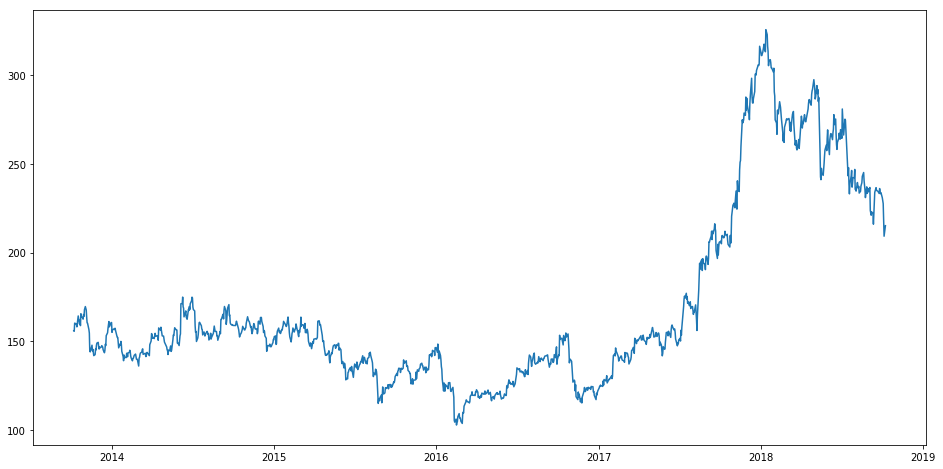

In [5]:
plt.figure(figsize=(16,8))
plt.plot(stock['Close'], label="Close Price of Stock")

# Moving Average Model:

The moving average model is a very simple model. Basically, we estimate the price of the stock by taking the average of a set of previous values. Note that we do not want to take the average of all of our past data because the trend of our data varies with time. This technique of taking the average out of a section of our past data is called the **Moving Average**.

The formula for moving average is:
\begin{equation}
    Moving Average = \frac{P_1+P_2+...+P_n}{n}
\end{equation}
where $P_n$ is the price of the stock at time index n. And n is an integer value that dictates how far into the past you look to take your average.

Okay, so let's move on to implementation, first let's create a new dataframe which contains the Date and Close price of our stock and then we will perform a train-test split on this data so that we can see how well our model is performing.

In [6]:
#Sort the data by Date in ascending order
stock = stock.sort_index(ascending=True, axis=0)
stock.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2013-10-08,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
2013-10-09,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2013-10-10,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
2013-10-11,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
2013-10-14,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


In [7]:
#Create a new dataset that contains only the date and closing value of the stock
new_data = pd.DataFrame(index = range(len(stock)), columns=['Date','Close'])

for i in range(len(stock)):
    new_data['Date'][i] = stock['Date'][i]
    new_data['Close'][i] = stock['Close'][i]
new_data.head()

,Date,Close
0,2013-10-08 00:00:00,155.8
1,2013-10-09 00:00:00,155.55
2,2013-10-10 00:00:00,160.15
3,2013-10-11 00:00:00,160.05
4,2013-10-14 00:00:00,159.45


In time-series data, we cannot split our data randomly because that would destroy the time component of our data. Instead we will use the last year's data as validation while we use the rest as training data.

In [8]:
train = new_data[:987]
test = new_data[987:]

In [9]:
test.index

RangeIndex(start=987, stop=1235, step=1)

In [10]:
#Check shape of our data, new_data.shape[0] = train.shape[0] + test.shape[0]
print(new_data.shape)
print(train.shape)
print(test.shape)

(1235, 2)
(987, 2)
(248, 2)


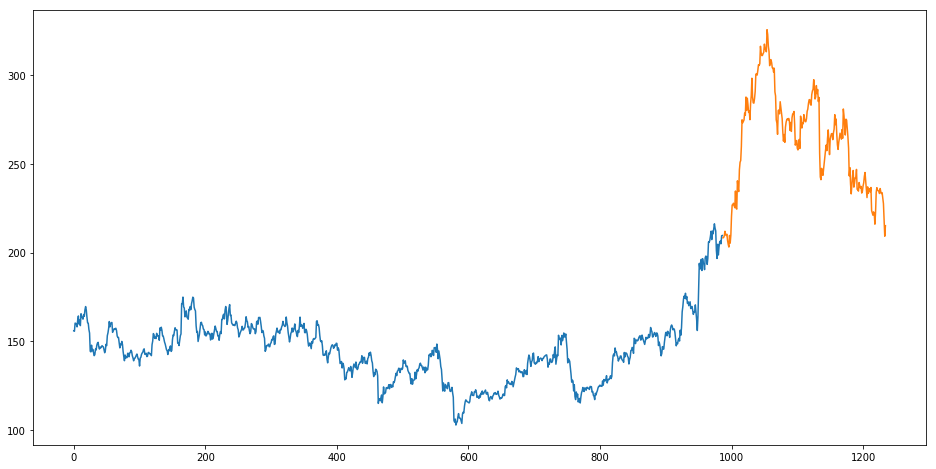

In [11]:
#plot the train and test data just to check to see if we did our splitting correctly.
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(test['Close'])

So we can confirm that our splitting was done properly, let us move on and implement the moving average model.

In [12]:
preds = []
for i in range(0,248):
    a = train['Close'][len(train)-200+i:].sum() + sum(preds)
    b = a/200
    preds.append(b)

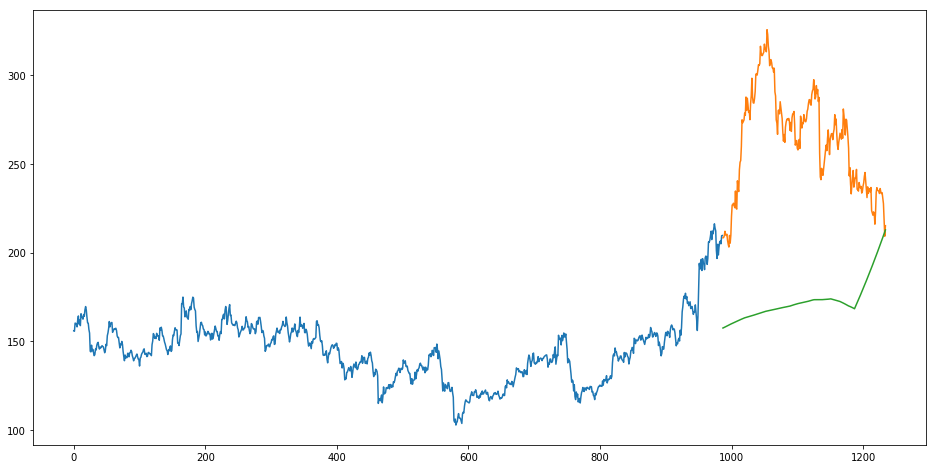

In [13]:
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(test['Close'])
plt.plot(range(987,1235),preds)
# plt.plot(pred_stock['Close'])

In [14]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(test['Close'])-preds),2)))
rms

96.33881577676058

So as we can see from the graph, our moving average model actually performs quite poorly. Hopefully our other models fair better.

# ARIMA Models:

Our next model is called the auto regressive (AR), integrated (I), moving average (MA) model. It is an advanced statistical method for modelling time-series data by using past data to estimate future values. There are three parameters for the ARIMA model:
- p (past values used for forecasting the future values)
- q (pase forecast errors used to predict future values)
- d (order of differencing)

There are lots of ways to tune an ARIMA model, perhaps the most famous one is called the <a href="https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method">box-jenkins</a> method, but in this notebook we will use an AUTO ARIMA.

In [15]:
model = auto_arima(train['Close'], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1,
                  trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train['Close'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4820.561, BIC=4844.968, Fit time=3.903 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5479.245, BIC=5489.008, Fit time=0.052 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5170.275, BIC=5189.801, Fit time=0.771 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4818.529, BIC=4838.055, Fit time=2.838 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4816.433, BIC=4840.840, Fit time=1.908 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5170.275, BIC=5189.801, Fit time=0.656 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4818.339, BIC=4847.628, Fit time=10.621 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5481.156, BIC=5495.800, Fit time=0.238 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=4818.604, BIC=4852.774, Fit time=7.610 seconds
Fit ARIMA: order=(1, 1, 1) 

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [16]:
forecast = model.predict(n_periods=248)
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

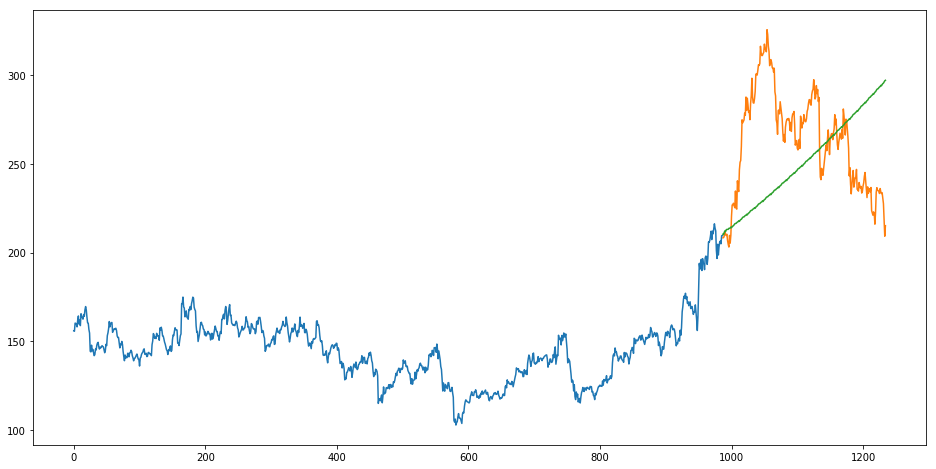

In [17]:
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(test['Close'])
plt.plot(range(987,1235),forecast)

In [18]:
rms=np.sqrt(np.mean(np.power((np.array(test['Close'])-np.array(forecast['Prediction'])),2)))
rms

44.95458499324695

So as we can see from the graph, the ARIMA model does a much better job at forecasting.

# Prophet Model:

We now move on to the Prophet model, which was designed by Facebook. The advantage of this model is that it decomposes a time series model into very intuitive parts that are simple for people to wrap their heads around. The prophet time series model can be modelled as follows:

\begin{equation}
    y(t) = g(t) + s(t) + h(t) + \epsilon_t
\end{equation}

- g(t): Is the piecewise linear or logistic growth curve. It is used for modelling non-periodic changes in a time-series.
- s(t): Periodic Changes (weekly/yearly/seasonaly)
- h(t): The effects of holidays with irregular schedules
- $\epsilon_t$: the error term

In [63]:
#Create new dataframe for prophet model
prophet_data = pd.DataFrame(index = range(len(stock)), columns = ['Date','Close'])

for i in range(len(stock)):
    prophet_data['Date'][i] = stock['Date'][i]
    prophet_data['Close'][i] = stock['Close'][i]
    
    
prophet_data['Date'] = pd.to_datetime(prophet_data.Date,format='%Y-%m-%d')
prophet_data.index = prophet_data['Date']


#Rename Data to fit prophet standards
prophet_data.rename(columns={'Close': 'y', 'Date':'ds'}, inplace=True)

#Train/test split
prophet_train = prophet_data[:987]
prophet_test = prophet_data[987:]

#Fit the model
model = Prophet()
model.fit(prophet_train)

#Make Predictions
close_prices = model.make_future_dataframe(periods=len(prophet_test))
predict = model.predict(close_prices)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [64]:
predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-10-08,149.643379,148.938524,167.556913,149.643379,149.643379,8.570212,8.570212,8.570212,-1.509061,-1.509061,-1.509061,10.079273,10.079273,10.079273,0.0,0.0,0.0,158.213591
1,2013-10-09,149.675037,149.859137,167.760353,149.675037,149.675037,8.952475,8.952475,8.952475,-1.374054,-1.374054,-1.374054,10.326530,10.326530,10.326530,0.0,0.0,0.0,158.627513
2,2013-10-10,149.706695,149.889968,168.832129,149.706695,149.706695,9.328702,9.328702,9.328702,-1.259577,-1.259577,-1.259577,10.588279,10.588279,10.588279,0.0,0.0,0.0,159.035397
3,2013-10-11,149.738354,149.266005,169.478308,149.738354,149.738354,9.716465,9.716465,9.716465,-1.140933,-1.140933,-1.140933,10.857397,10.857397,10.857397,0.0,0.0,0.0,159.454818
4,2013-10-14,149.833328,150.400996,169.571198,149.833328,149.833328,10.340952,10.340952,10.340952,-1.289612,-1.289612,-1.289612,11.630564,11.630564,11.630564,0.0,0.0,0.0,160.174280


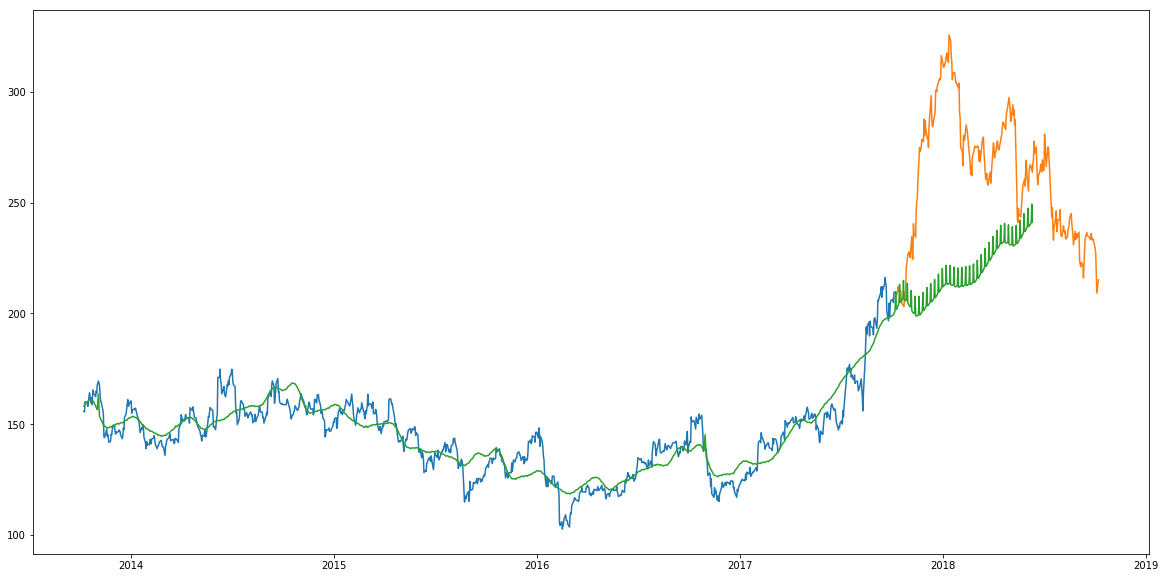

In [65]:
#Plot the results
plt.plot(prophet_train['y'])
plt.plot(prophet_test['y'])
plt.plot(predict['ds'],predict['yhat'])

In [67]:
#rmse
prediction = predict['yhat'][987:]
rms=np.sqrt(np.mean(np.power((np.array(prophet_test['y'])-np.array(prediction)),2)))
rms

57.461756853455086

So we can see that both ARIMA and Prophet models have similar performances with this particular stock data. The strengths with ARIMA and prophet models are in their ability to model seasonality and trends of the data. However stock prices are often unpredictable and lack any sense of trend and seasonality. This is why these models tend to do poorly on stock data.